In [30]:
import albumentations as A
import os
from tqdm import tqdm
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import to_categorical

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
DATASET_DIR = ("/content/drive/MyDrive/HandGesture/images")
LABELS = os.listdir(DATASET_DIR)
IMAGE_SIZE = (195, 195)

In [33]:
IMAGES = []
for label in LABELS:
    label_dir = os.path.join(DATASET_DIR, label)
    for img in tqdm(os.listdir(label_dir), desc=f"images for '{label}' --->"):
        img_np = cv2.imread(os.path.join(label_dir, img), cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.
        img_np = cv2.resize(img_np, IMAGE_SIZE)
        IMAGES.append({
            "img": img_np,
            "label": label,
            "label_num": LABELS.index(label)
            })


images for 'call_me' --->: 100%|██████████| 527/527 [00:03<00:00, 134.56it/s]


In [34]:
random.shuffle(IMAGES)

In [35]:
X_IMAGES, y_IMAGES = train_test_split(IMAGES, test_size=0.2, random_state=42)

In [36]:
X_train = []
y_train = []
for img in X_IMAGES:
    X_train.append(img["img"])
    y_train.append(img["label_num"])

X_test = []
y_test = []
for img in y_IMAGES:
    X_test.append(img["img"])
    y_test.append(img["label_num"])

In [37]:
X_train = np.array(X_train).reshape(-1, *IMAGE_SIZE)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, *IMAGE_SIZE)
y_test = np.array(y_test)
y_train_encoded = to_categorical(y_train, num_classes=len(LABELS))
y_test_encoded = to_categorical(y_test, num_classes=len(LABELS))

In [38]:
print(X_train.shape)
print(y_train.shape)
print(y_train_encoded.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_encoded.shape)

(4194, 195, 195)
(4194,)
(4194, 10)
(1049, 195, 195)
(1049,)
(1049, 10)


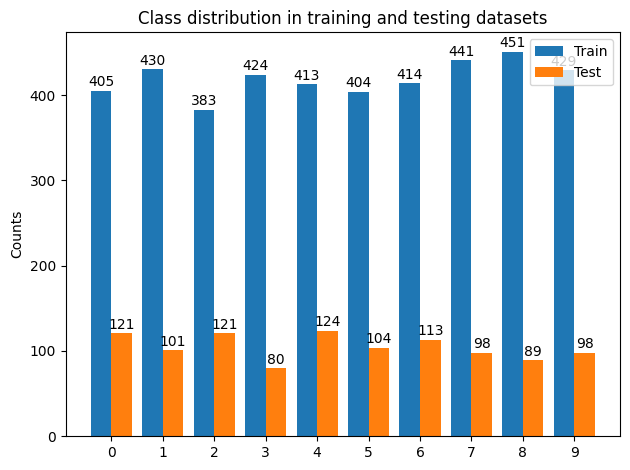

In [39]:
from collections import Counter


def visualize_class_distribution(y_train, y_test):
    """
    Visualizes the class distribution in training and testing datasets when the labels are provided as lists.
    Adds a numeric label at the top of each bar showing the count.

    Parameters:
    - y_train: List of training labels.
    - y_test: List of testing labels.
    """
    train_counter = Counter(y_train)
    test_counter = Counter(y_test)

    all_labels = list(set(train_counter.keys()).union(set(test_counter.keys())))
    all_labels.sort()  # Sort the labels for consistent plotting
    train_counts = [train_counter[label] for label in all_labels]
    test_counts = [test_counter[label] for label in all_labels]

    x = range(len(all_labels))  # Label locations

    fig, ax = plt.subplots()
    train_bars = ax.bar([i - 0.2 for i in x], train_counts, width=0.4, label='Train', align='center')
    test_bars = ax.bar([i + 0.2 for i in x], test_counts, width=0.4, label='Test', align='center')

    ax.set_ylabel('Counts')
    ax.set_title('Class distribution in training and testing datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation='horizontal')
    ax.legend()

    def autolabel(bars):
        """Attach a text label above each bar displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(train_bars)
    autolabel(test_bars)

    plt.tight_layout()
    plt.show()

visualize_class_distribution(y_train, y_test)

In [53]:
model = Sequential(
    [
        Conv2D(64, (5, 5), activation="relu", input_shape=(*IMAGE_SIZE, 1)),
        MaxPooling2D((3, 3)),
        Dropout(0.25),  # Add dropout for regularization
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        Conv2D(256, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(len(LABELS), activation="softmax")
    ]
)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test[:60], y_test_encoded[:60]))

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.1831 - loss: 2.1972 - precision: 0.5157 - recall: 0.0367 - val_accuracy: 0.7833 - val_loss: 0.7035 - val_precision: 0.9500 - val_recall: 0.6333
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6458 - loss: 1.0087 - precision: 0.7788 - recall: 0.5167 - val_accuracy: 0.9333 - val_loss: 0.2107 - val_precision: 0.9643 - val_recall: 0.9000
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8252 - loss: 0.5491 - precision: 0.8717 - recall: 0.7606 - val_accuracy: 0.9333 - val_loss: 0.1431 - val_precision: 0.9655 - val_recall: 0.9333
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8873 - loss: 0.3408 - precision: 0.9116 - recall: 0.8660 - val_accuracy: 0.9500 - val_loss: 0.1716 - val_precision: 0.9649 - val_recall: 0.9167
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9193 - loss: 0.2364 - precision: 0.9375 - recall: 0.9018 - val_accuracy: 0.9500 - val_

In [55]:
prediction = model.predict(X_test)
pred = np.argmax(prediction, axis=1)
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, pred)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.9561487130600572
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       121
           1       1.00      0.97      0.98       101
           2       0.96      0.98      0.97       121
           3       0.95      0.99      0.97        80
           4       0.97      0.99      0.98       124
           5       0.99      0.99      0.99       104
           6       0.93      0.85      0.89       113
           7       0.90      0.95      0.93        98
           8       0.99      0.92      0.95        89
           9       0.99      0.97      0.98        98

    accuracy                           0.96      1049
   macro avg       0.96      0.96      0.96      1049
weighted avg       0.96      0.96      0.96      1049



In [56]:
model.save('/content/drive/MyDrive/HandGesture/CNN_with_dropout.h5')

# Load the model
loaded_model = load_model('/content/drive/MyDrive/HandGesture/CNN_with_dropout.h5')
